# BZ integration

In [1]:
using PyPlot
using Cuba

We want to perform numerical integralation of vector data over the BZ zone.
This is not aways easy because the integrand can vary rapidly in small regions.
Here, adaptive integral kicks in.
For instance, we can integrate a function which evaluate to two normal distributions with different variances on the three-dimensional unit hypercube $[0,1]^3$.

In [2]:
norm_dist(x, σ) = exp(-sum(x.^2)/(2*σ^2))/(σ*sqrt(2π))^3
function norm_dist_v(x, f)
    f[1] = norm_dist(x, 0.01)
    f[2] = norm_dist(x, 0.001)
end
cuhre(norm_dist_v, 3, 2)

Components:
 1: 0.12499894817062472 ± 7.896673363781687e-6 (prob.: 1.1102230246251565e-16)
 2: 0.12499977121633674 ± 8.42146746466239e-6 (prob.: 0.0)
Integrand evaluations: 15875
Number of subregions:  63
Note: The desired accuracy was reached

As a simple example, we consider a multi-orbital model with a cos-like band dispersion:

$$
\epsilon(b, k_x, k_y, k_z) = 2 \cos(k_x) + 2 \cos(k_y) + 2 \cos(k_z) + \epsilon_0(b).
$$

The corresponding orbital occupation is given by

$$
n(b, k_x, k_y, k_z) = \frac{1}{(2\pi)^3} \int_{-\pi}^\pi dk_x dk_y dk_z \frac{1}{1+\exp(\beta \epsilon(b, k_x, k_y, k_z))}.
$$

It is hard to integrate the orbital occupation at low $T$.

First, we define `mycuhre` for numerical integraion on a general hypercube.

In [3]:
function mycuhre(integrand, ndim, ncomp, xmin, xmax)
    function integrand_scaled(x, f)
        integrand((xmax - xmin)*x .+ xmin, f)
        f .*= (xmax - xmin)^ndim
    end
    cuhre(integrand_scaled, ndim, ncomp, maxevals=100000000)
end

mycuhre(norm_dist_v, 3, 2, -1, 1)

Components:
 1: 1.000144412485981 ± 9.93436986411435e-5 (prob.: 0.0)
 2: 1.0000371976250122 ± 9.98556800753735e-5 (prob.: 1.1102230246251565e-16)
Integrand evaluations: 226187
Number of subregions:  891
Note: The desired accuracy was reached

This works great at high $T$. But, if we increase $\beta$ to 100, you will not get correct results in the following cell.

In [4]:
β = 10.0
ϵ0 = [-0.1, 0.0, 0.1]

fdist(ϵ) = 1/(1 + exp(β*ϵ))
ek(kx, ky, kz) = 2 * (cos(kx) + cos(ky) + cos(kz)) .+ ϵ0
nk(kx, ky, kz) = fdist.(ek(kx, ky, kz))

r = mycuhre( (x,f)->f.=nk(x...), 3, length(ϵ0), -π, π)
println(r)
println(r[1]/(2π)^3)

Components:
 1: 127.56384239093332 ± 0.012745344451511759 (prob.: 0.0)
 2: 124.02479357916016 ± 0.012127496929582178 (prob.: 0.0)
 3: 120.48675897098559 ± 0.012034784667174454 (prob.: 0.0)
Integrand evaluations: 639191
Number of subregions:  2517
Note: The desired accuracy was reached
[0.5142662069128023, 0.4999987375860929, 0.48573535696216874]


This is because the orbital occupation is a nearly step function. See below.

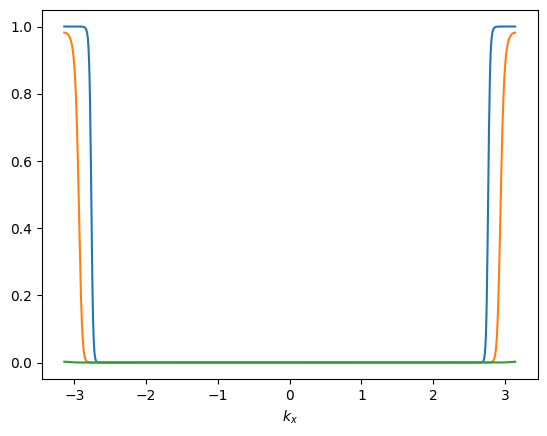

In [5]:
β = 100.0
kxs = range(-π, π, length=1000)
ys = [nk(kx, 0.5π, 0.2) for kx in kxs]
plt.plot(kxs, ys)
plt.xlabel(raw"$k_x$")
;

A commonstrategy is to use **the tetrahedron method**.
The tetrahedron method relys on linear interpolation of band dispersions, which are very smooth functions.
In this note, however, we strick to adaptive numerical integration.
Our strategy is to integrate out wave vectors one by one.

In [6]:
using Cubature
hquadrature(length(ϵ0), (x,f)->f.=nk(x[1], 0.5π, 0.2), -π, π)

([0.7508236899342619, 0.3874311949621099, 0.00043305916104926113], [2.08208417964383e-11, 1.7437834083154254e-9, 4.95352590822916e-18])

In [53]:
function adaptive_bz_integration(integrand, ncomp)
    function integrand_kxky(kxky, f)
        kx, ky = kxky
        v, e = hquadrature(ncomp, (x,f_)->integrand([kx, ky, x[1]], f_), -π, π)
        f .= v
    end
    function integrand_kx(kx, f)
        v, e = hquadrature(ncomp, (x,f_)->integrand_kxky([kx, x[1]],f_), -π, π)
        f .= v
    end
    hquadrature(ncomp, (x,f)->integrand_kx(x[1],f), -π, π)
end

adaptive_bz_integration (generic function with 1 method)

In [56]:
β = 10.0
@time res = adaptive_bz_integration((x,f)->f.=nk(x...), length(ϵ0))
res ./(2π)^3

 91.002551 seconds (1.78 G allocations: 49.263 GiB, 6.58% gc time)


([0.5142690494629448, 0.49999999999734934, 0.48573095052886617], [3.5679912142253788e-9, 4.4316624753774944e-10, 2.888566998015395e-13])

In [ ]:
#β = 100.0
#@time res = adaptive_bz_integration((x,f)->f.=nk(x...), length(ϵ0))
#res ./(2π)^3